
# Data augmentation


In [ ]:
pip install requests

In [ ]:
pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install mistral

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.3/209.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 14.7 MB/s eta 0:00:00

In [ ]:
import json
import time
import random
import re
from mistralai import Mistral

def extract_json_from_text(response_text):
    """
    Recherche et extrait un objet JSON valide à partir du texte de la réponse.
    Cherche la partie entourée par des backticks, puis tente de charger le JSON.
    Retourne l'objet JSON si trouvé, sinon None.
    """
    # Rechercher le JSON entouré de backticks
    json_pattern = r'```json\n\{.*\}\n```'  # Expression régulière pour attraper un bloc JSON entre backticks
    match = re.search(json_pattern, response_text, re.DOTALL)  # re.DOTALL permet de capter les nouvelles lignes

    if match:
        json_str = match.group(0)
        # Enlever les backticks et les éventuelles nouvelles lignes autour
        json_str = json_str.strip('```json\n').strip('\n```')
        try:
            return json.loads(json_str)  # Tenter de charger le JSON
        except json.JSONDecodeError:
            print("Erreur lors du parsing du JSON extrait.")
            return None
    else:
        print("Aucun JSON valide trouvé dans la réponse.")
        return None

def get_only_chars(line):
    """
    Nettoie la ligne en retirant les caractères non alphabétiques et en normalisant la casse.
    """
    clean_line = ""
    line = line.replace("’", "").replace("'", "").replace("-", " ").replace("\t", " ").replace("\n", " ").lower()
    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '
    clean_line = re.sub(' +', ' ', clean_line).strip()
    return clean_line

async def call_mistral(prompt, sentence):
    """
    Effectue un appel API vers Mistral pour générer du texte en fonction du prompt et de la phrase.
    Mistral est responsable de générer les variations de la phrase ou autres modifications demandées.
    """
    API_KEY = "your-mistral-api-key"  # Ta clé API ici
    MODEL_NAME = "ministral-8b-2410"  # Remplacer par le modèle spécifique que tu veux utiliser

    # Ajouter un délai de 1.5 seconde
    time.sleep(1.5)

    # Initialisation du client Mistral avec la clé API et le modèle
    client = Mistral(api_key=API_KEY)

    try:
        # Appel à Mistral pour générer du texte en fonction du prompt et de la phrase
        chat_response = await client.chat.complete_async(
            model=MODEL_NAME,
            temperature=0.3,
            max_tokens=256,
            messages=[{
                "role": "user",
                "content": prompt,
            }]
        )


        # Récupérer la réponse du texte généré
        response_text = chat_response.choices[0].message.content  # Assurez-vous que "generated_text" est le bon champ dans la réponse

        # Tenter d'extraire et de parser le JSON à partir du texte
        response_json = extract_json_from_text(response_text)

        return response_json['sentences']  # Retourner la réponse sous forme de dictionnaire

    except Exception as e:
        print(f"Erreur lors de l'appel à Mistral : {e}")
        return None

async def synonym_replacement(sentence, n):
    """
    Mistral génère une augmentation de données supervisées en remplaçant `n` mots par des synonymes.
    La tâche de génération des synonymes est à la charge du modèle LLM.
    """
    prompt = f"""
    Effectue une augmentation de données en remplaçant exactement {n} mots de la phrase suivante par des synonymes.
    Les synonymes doivent être choisis de manière à préserver le sens original de la phrase, sans introduire d'ambiguïté.
    Les mots remplacés doivent être courants et bien compris, en évitant les termes trop techniques ou peu usités.
    Retourne les résultats sous forme de JSON. Exemple de réponse attendu :
    {{"sentences": "phrase modifiée"}}

    Voici la phrase à modifier : {sentence}
    """
    return await call_mistral(prompt, sentence)

async def random_deletion(sentence, p):
    """
    Mistral supprime certains mots de la phrase avec une probabilité de `p`, tout en préservant le sens.
    La tâche de suppression est effectuée par le modèle LLM.
    """
    prompt = f"""
    Effectue une augmentation de données en supprimant certains mots de la phrase suivante avec une probabilité de {p}.
    Les mots supprimés doivent être choisis de manière à ne pas altérer le sens global de la phrase.
    Évite de supprimer des mots essentiels comme des verbes, des noms importants, ou des mots qui sont cruciaux pour la structure grammaticale de la phrase.
    Retourne les résultats sous forme de JSON. Exemple de réponse attendu :
    {{"sentences": "phrase modifiée"}}

    Voici la phrase à modifier : {sentence}
    """
    return await call_mistral(prompt, sentence)

async def random_swap(sentence, n):
    """
    Mistral échange `n` mots dans la phrase tout en préservant le sens global.
    La tâche d'échange de mots est effectuée par le modèle LLM.
    """
    prompt = f"""
    Effectue une augmentation de données en échangeant {n} mots dans la phrase suivante tout en préservant le sens global.
    Assure-toi que les mots échangés sont de nature similaire, sans changer la signification de la phrase.
    Évite de modifier l'ordre des mots qui affectent le sens principal de la phrase.
    Retourne les résultats sous forme de JSON. Exemple de réponse attendu :
    {{"sentences":"phrase modifiée"}}

    Voici la phrase à modifier : {sentence}
    """
    return await call_mistral(prompt, sentence)

async def random_insertion(sentence, n):
    """
    Mistral insère `n` mots contextuellement pertinents dans la phrase tout en préservant son sens.
    La tâche d'insertion est effectuée par le modèle LLM.
    """
    prompt = f"""
    Effectue une augmentation de données en insérant {n} mots contextuellement pertinents dans la phrase suivante.
    Les nouveaux mots doivent être insérés sans altérer le sens de la phrase et doivent être naturellement intégrés.
    Assure-toi que la phrase reste fluide et compréhensible après l'insertion des mots.
    Retourne les résultats sous forme de JSON. Exemple de réponse attendu :
    {{"sentences": "phrase modifiée"}}

    Voici la phrase à modifier : {sentence}
    """
    return await call_mistral(prompt, sentence)

async def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
    """
    Effectue une augmentation de données supervisées avec plusieurs techniques, en appelant Mistral pour chaque tâche.
    Mistral est responsable de l'application des différentes techniques d'augmentation des données.
    """
    sentence = get_only_chars(sentence)
    augmented_sentences = []
    num_new_per_technique = (num_aug // 4) + 1

    if alpha_sr > 0:
        for _ in range(num_new_per_technique):
            result = await synonym_replacement(sentence, max(1, int(alpha_sr * len(sentence.split()))))
            if result is not  None:
              augmented_sentences.append(result)  # Récupérer les phrases du JSON

    if alpha_ri > 0:
        for _ in range(num_new_per_technique):
            result = await random_insertion(sentence, max(1, int(alpha_ri * len(sentence.split()))))
            if result is not  None:
              augmented_sentences.append(result)  # Récupérer les phrases du JSON

    if alpha_rs > 0:
        for _ in range(num_new_per_technique):
            result = await random_swap(sentence, max(1, int(alpha_rs * len(sentence.split()))))
            if result is not  None:
              augmented_sentences.append(result)  # Récupérer les phrases du JSON

    if p_rd > 0:
        for _ in range(num_new_per_technique):
            result = await random_deletion(sentence, p_rd)
            if result is not None:
              augmented_sentences.append(result)  # Récupérer les phrases du JSON
    # si augmented sentences est list
    if isinstance(augmented_sentences, list):
        print("augmente list",augmented_sentences )
        augmented_sentences = [s for s in augmented_sentences if not s.isspace()]
    if isinstance(augmented_sentences, str):
        augmented_sentences = [augmented_sentences]

    augmented_sentences.append(sentence)
    return augmented_sentences


In [ ]:
result = await  synonym_replacement("je suis amine",1)
print(result)
result= await random_deletion("je suis amine",1)
print(result)
result= await random_swap("je suis amine",1)
print(result)
result= await random_insertion("je suis amine",1)
print(result)

je suis amina
amine
je suis amina
je suis un ami


In [ ]:
output="/content/output/augmented_sst2_train_500.json"
trainn_orig="/content/train/sst2_train_500.txt"
#number of augmented sentences to generate per original sentence
num_aug = 4
import json

async def gen_eda(train_orig, output_file, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, alpha_rd=0.1, num_aug=1):
    lines = open(train_orig, 'r').readlines()

    # Vérifier si le fichier existe déjà et charger son contenu
    try:
        with open(output_file, 'r') as f:
            aug_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        aug_data = []

    for i, line in enumerate(lines):
        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue  # Ignorer les lignes mal formatées

        label = parts[0]
        sentence = parts[1]
        print("sentence =", sentence)

        aug_sentences = await eda(sentence, alpha_sr=alpha_sr, alpha_ri=alpha_ri, alpha_rs=alpha_rs, p_rd=alpha_rd, num_aug=num_aug)
        print("aug_sentences = ",aug_sentences)
        # if it'ss  list
        if isinstance(aug_sentences, list):
          for aug_sentence in aug_sentences:
              aug_data.append({"label": label, "sentence": aug_sentence})
        # if it( str
        elif isinstance(aug_sentences, str):
          aug_data.append({"label": label, "sentence": aug_sentences})
        else:
          print(f"Unexpected type for aug_sentences: {type(aug_sentences)}")

    # Écriture finale de toutes les données augmentées dans le fichier JSON
    with open(output_file, 'w') as f:
        json.dump(aug_data, f, indent=4)

    print(f"Generated augmented sentences with EDA for {train_orig} and saved to {output_file} with num_aug={num_aug}")
    return True


In [ ]:
result= await gen_eda(train_orig=trainn_orig ,output_file=output)

sentence = neil burger here succeeded in making the mystery of four decades back the springboard for a more immediate mystery in the present
augmente list ['Neil Burger here succeeded in making the enigma of four decades back the springboard for a more immediate enigma in the present', 'Neil Burger here succeeded in making the mystery of four decades back the springboard for a more immediate mystery in the present.', 'neil burger here succeeded in making the mystery of four decades back the springboard for a more immediate mystery in the present', 'Neil Burger here succeeded in making the mystery of four decades back the springboard for a more immediate mystery in the present.']
aug_sentences =  ['Neil Burger here succeeded in making the enigma of four decades back the springboard for a more immediate enigma in the present', 'Neil Burger here succeeded in making the mystery of four decades back the springboard for a more immediate mystery in the present.', 'neil burger here succeeded i

In [ ]:
print(result)

True


# Data cleaning &  exploration

In [ ]:
import pandas as pd
import json

# Lire le JSON dans un dataframe
# Supposons que vos données sont dans un fichier 'data.json'
# Si les données sont dans une variable, vous pouvez simplement faire:
# df = pd.DataFrame(json_data)

# Méthode 1: Si vos données sont dans un fichier
df_augmented = pd.read_json('/content/output/augmented_sst2_train_500.json')

# Méthode 2: Si vos données sont dans une variable (chaîne de caractères)
# json_str = '[{"label": "1", "sentence": ""}, {"label": "1", "sentence": "neil burger here..."}]'
# data = json.loads(json_str)
# df = pd.DataFrame(data)

# Nettoyage des données
# 1. Supprimer les lignes où label est None
# 2. Supprimer les lignes où sentence est None
# 3. Supprimer les lignes où sentence ne contient qu'une seule lettre
df_augmented_clean = df_augmented.dropna(subset=['label', 'sentence'])
df_augmented_clean = df_augmented_clean[df_augmented_clean['sentence'].str.len() > 1]
#delete duplicated
df_augmented_clean = df_augmented_clean.drop_duplicates(subset=['sentence'])

print(f"Nombre d'entrées avant nettoyage: {len(df_augmented)}")
print(f"Nombre d'entrées après nettoyage: {len(df_augmented_clean)}")
print(df_augmented_clean.head())

Nombre d'entrées avant nettoyage: 2268
Nombre d'entrées après nettoyage: 1627
   label                                           sentence
0      1  Neil Burger here succeeded in making the enigm...
1      1  Neil Burger here succeeded in making the myste...
2      1  neil burger here succeeded in making the myste...
5      0  it is a visual inkblot test and i must have fa...
6      0  it is a visual rorschach test and i must have ...


In [ ]:
import pandas as pd

# Lire le fichier texte tabulé
# Le fichier est au format "label<tab>sentence"
df = pd.read_csv('/content/train/sst2_train_500.txt', sep='\t', header=None, names=['label', 'sentence'])

# Nettoyage des données
# 1. Supprimer les lignes où label est None
# 2. Supprimer les lignes où sentence est None
# 3. Supprimer les lignes où sentence ne contient qu'une seule lettre
df_clean = df.dropna(subset=['label', 'sentence'])
df_clean = df_clean[df_clean['sentence'].str.len() > 1]

print(f"Nombre d'entrées avant nettoyage: {len(df)}")
print(f"Nombre d'entrées après nettoyage: {len(df_clean)}")
print(df_clean.head())

Nombre d'entrées avant nettoyage: 500
Nombre d'entrées après nettoyage: 500
   label                                           sentence
0      1  neil burger here succeeded in making the myste...
1      0  it is a visual rorschach test and i must have ...
2      0  the only way to tolerate this insipid brutally...
3      0  scores no points for originality wit or intell...
4      0  it would take a complete moron to foul up a sc...


In [ ]:
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall gensim

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [ ]:
!pip install numpy==1.24.4
!pip install --upgrade --force-reinstall scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


Prétraitement des textes...
Entraînement du modèle Word2Vec...
Calcul des vecteurs de phrases...
Réduction de dimensionnalité avec PCA...
Variance expliquée par les composantes: [9.992993e-01 5.992121e-05]
Variance expliquée totale: 1.00
Création de la visualisation...


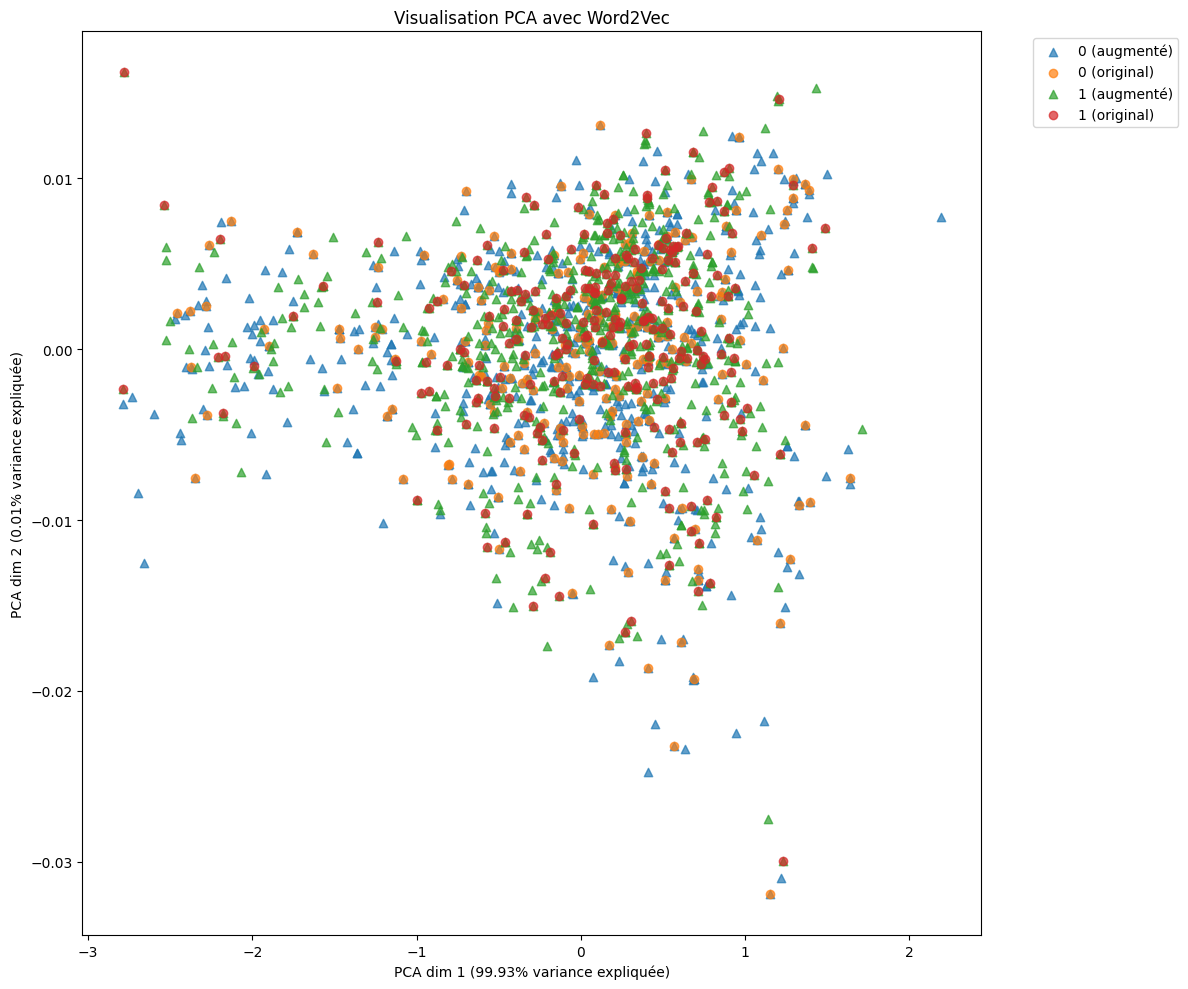


Distribution des labels:
label       0    1
source            
augmenté  777  850
original  244  256


<Figure size 1000x600 with 0 Axes>

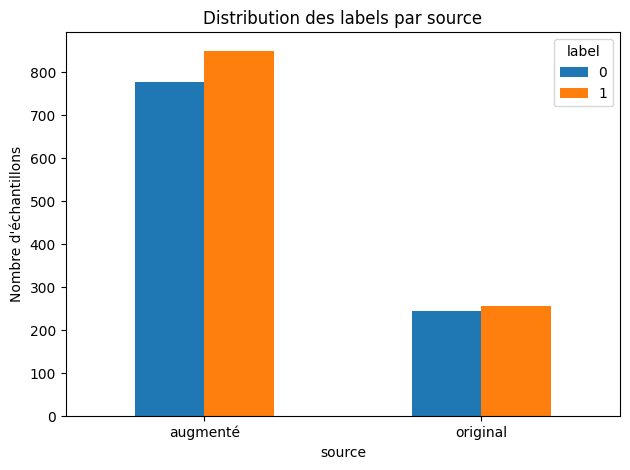

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import plotly.express as px

# Combiner les dataframes avec une colonne pour indiquer l'origine
df_original = df_clean.copy()
df_original['source'] = 'original'
df_augmented = df_augmented_clean.copy()
df_augmented['source'] = 'augmenté'

# Concaténer les deux dataframes
df_combined = pd.concat([df_original, df_augmented], ignore_index=True)

# Convertir les labels en chaînes de caractères pour s'assurer qu'ils sont du même type
df_combined['label'] = df_combined['label'].astype(str)

# Prétraitement des textes
print("Prétraitement des textes...")
df_combined['tokens'] = df_combined['sentence'].apply(lambda x: simple_preprocess(x))

# Entraîner le modèle Word2Vec
print("Entraînement du modèle Word2Vec...")
w2v_model = Word2Vec(sentences=df_combined['tokens'],
                    vector_size=100,
                    window=5,
                    min_count=1,
                    workers=4)

# Fonction pour obtenir le vecteur moyen d'une phrase
def get_sentence_vector(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculer les vecteurs de phrases
print("Calcul des vecteurs de phrases...")
df_combined['vector'] = df_combined['tokens'].apply(lambda x: get_sentence_vector(x, w2v_model))

# Extraire les vecteurs pour PCA
vectors = np.array(df_combined['vector'].tolist())

# Appliquer PCA au lieu de t-SNE
print("Réduction de dimensionnalité avec PCA...")
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(vectors)
df_combined['pca_x'] = pca_results[:, 0]
df_combined['pca_y'] = pca_results[:, 1]

# Afficher le pourcentage de variance expliquée
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par les composantes: {explained_variance}")
print(f"Variance expliquée totale: {sum(explained_variance):.2f}")

# Visualisation avec Plotly
print("Création de la visualisation...")

# Créer une palette de couleurs personnalisée pour les labels
num_labels = df_combined['label'].nunique()
colors = px.colors.qualitative.Plotly[:num_labels]
color_map = {label: colors[i] for i, label in enumerate(df_combined['label'].unique())}

# Créer le graphique interactif
fig = px.scatter(
    df_combined,
    x='pca_x',
    y='pca_y',
    color='label',
    symbol='source',
    symbol_map={'original': 'circle', 'augmenté': 'diamond'},
    color_discrete_map=color_map,
    hover_data=['sentence'],
    title='Visualisation PCA avec Word2Vec: données originales vs augmentées',
    labels={'pca_x': 'PCA dim 1', 'pca_y': 'PCA dim 2'},
    height=700,
    width=900
)

# Ajouter l'information sur la variance expliquée aux axes
fig.update_xaxes(title=f"PCA dim 1 ({explained_variance[0]:.2%} variance expliquée)")
fig.update_yaxes(title=f"PCA dim 2 ({explained_variance[1]:.2%} variance expliquée)")

# Améliorer le style
fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    legend_title_text='Classes et Sources',
    plot_bgcolor='white',
    margin=dict(l=20, r=20, t=60, b=20),
)

# Afficher le graphique
fig.show()

# Version basique avec Matplotlib (alternative à Plotly)
plt.figure(figsize=(12, 10))
groups = df_combined.groupby(['label', 'source'])

for name, group in groups:
    label, source = name
    marker = 'o' if source == 'original' else '^'
    plt.scatter(group['pca_x'], group['pca_y'],
                marker=marker,
                label=f"{label} ({source})",
                alpha=0.7)

plt.title('Visualisation PCA avec Word2Vec')
plt.xlabel(f'PCA dim 1 ({explained_variance[0]:.2%} variance expliquée)')
plt.ylabel(f'PCA dim 2 ({explained_variance[1]:.2%} variance expliquée)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Statistiques sur la distribution des labels
print("\nDistribution des labels:")
label_counts = df_combined.groupby(['source', 'label']).size().unstack(fill_value=0)
print(label_counts)

# Visualiser la distribution des labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution des labels par source')
plt.ylabel('Nombre d\'échantillons')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Vectorisation des textes avec TF-IDF...
Réduction de dimensionnalité avec PCA...
Variance expliquée par les composantes: [0.00565462 0.00463977]
Variance expliquée totale: 0.01
Création de la visualisation...


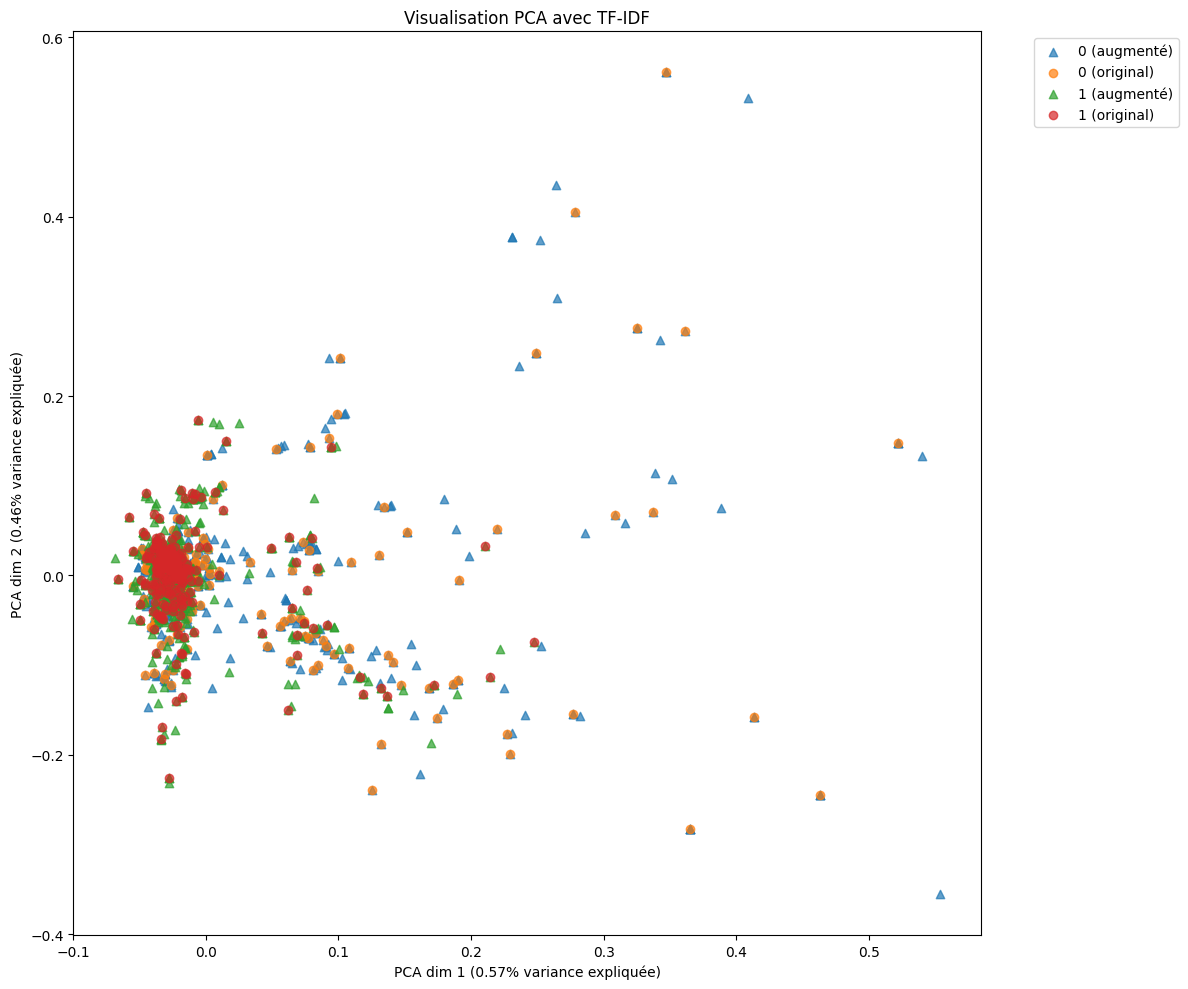


Distribution des labels:
label       0    1
source            
augmenté  777  850
original  244  256


<Figure size 1000x600 with 0 Axes>

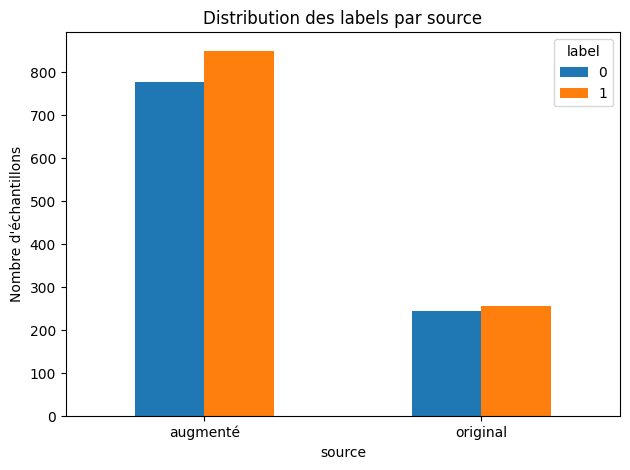

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px

# Combiner les dataframes avec une colonne pour indiquer l'origine
df_original = df_clean.copy()
df_original['source'] = 'original'
df_augmented = df_augmented_clean.copy()
df_augmented['source'] = 'augmenté'

# Concaténer les deux dataframes
df_combined = pd.concat([df_original, df_augmented], ignore_index=True)

# Convertir les labels en chaînes de caractères pour s'assurer qu'ils sont du même type
df_combined['label'] = df_combined['label'].astype(str)

# Utiliser TF-IDF au lieu de Word2Vec
print("Vectorisation des textes avec TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limiter le nombre de features
    min_df=2,           # Ignorer les termes qui apparaissent dans moins de 2 documents
    max_df=0.95,        # Ignorer les termes qui apparaissent dans plus de 95% des documents
    stop_words='english',
    ngram_range=(1, 2)  # Utiliser des unigrammes et des bigrammes
)

# Transformer les textes en vecteurs TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_combined['sentence'])

# Convertir la matrice sparse en array dense pour PCA
# Note: si la matrice est trop grande, vous pouvez la garder sparse jusqu'à l'étape PCA
tfidf_dense = tfidf_matrix.toarray()

# Appliquer PCA pour la réduction de dimensionnalité
print("Réduction de dimensionnalité avec PCA...")
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(tfidf_dense)
df_combined['pca_x'] = pca_results[:, 0]
df_combined['pca_y'] = pca_results[:, 1]

# Afficher le pourcentage de variance expliquée
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par les composantes: {explained_variance}")
print(f"Variance expliquée totale: {sum(explained_variance):.2f}")

# Visualisation avec Plotly
print("Création de la visualisation...")

# Créer une palette de couleurs personnalisée pour les labels
num_labels = df_combined['label'].nunique()
colors = px.colors.qualitative.Plotly[:num_labels]
color_map = {label: colors[i] for i, label in enumerate(df_combined['label'].unique())}

# Créer le graphique interactif
fig = px.scatter(
    df_combined,
    x='pca_x',
    y='pca_y',
    color='label',
    symbol='source',
    symbol_map={'original': 'circle', 'augmenté': 'diamond'},
    color_discrete_map=color_map,
    hover_data=['sentence'],
    title='Visualisation PCA avec TF-IDF: données originales vs augmentées',
    height=700,
    width=900
)

# Ajouter l'information sur la variance expliquée aux axes
fig.update_xaxes(title=f"PCA dim 1 ({explained_variance[0]:.2%} variance expliquée)")
fig.update_yaxes(title=f"PCA dim 2 ({explained_variance[1]:.2%} variance expliquée)")

# Améliorer le style
fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    legend_title_text='Classes et Sources',
    plot_bgcolor='white',
    margin=dict(l=20, r=20, t=60, b=20),
)

# Afficher le graphique
fig.show()

# Version basique avec Matplotlib (alternative à Plotly)
plt.figure(figsize=(12, 10))
groups = df_combined.groupby(['label', 'source'])

for name, group in groups:
    label, source = name
    marker = 'o' if source == 'original' else '^'
    plt.scatter(group['pca_x'], group['pca_y'],
                marker=marker,
                label=f"{label} ({source})",
                alpha=0.7)

plt.title('Visualisation PCA avec TF-IDF')
plt.xlabel(f'PCA dim 1 ({explained_variance[0]:.2%} variance expliquée)')
plt.ylabel(f'PCA dim 2 ({explained_variance[1]:.2%} variance expliquée)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Statistiques sur la distribution des labels
print("\nDistribution des labels:")
label_counts = df_combined.groupby(['source', 'label']).size().unstack(fill_value=0)
print(label_counts)

# Visualiser la distribution des labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution des labels par source')
plt.ylabel('Nombre d\'échantillons')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()